In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import caffe
import os
import lmdb
import cv2

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

local_model_path = '../models'
# local_net_path = '../net/nado_flow'
local_data_path = '../data_motion'
# deploy_proto = os.path.join(local_net_path, 'deploy.prototxt')
# mean_data = os.path.join(local_data_path, 'ratsi_mean.binaryproto')

# load labels
labels_file = os.path.join(local_data_path, 'labels.txt')
labels = np.loadtxt(labels_file, str, delimiter='\t')

In [2]:
# model_file = '/home/malte/Install/C3D/C3D-v1.1/examples/c3d_ucf101_training/conv3d_deepnetA_sport1m_iter_1900000.caffemodel'
# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vidcaf_motion/c3d_sports1m_original.prototxt'

weights = '/home/malte/Documents/Results/2017-03-13_VidCaf_motion/exp13/vidcaf_motion_iter_3316.caffemodel'
netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vidcaf_motion/deploy_2s.prototxt'
root_dataset = '/home/malte/datasets/RatSI/video_frames_128x128'

# weights = '/home/malte/Documents/Results/2017-03-17_VGG_VidCaf_SpatFusion/exp01/vgg_vidcaf_2stream_iter_3240.caffemodel'
# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg_vidcaf_2stream/deploy.prototxt'
caffe.set_mode_cpu()
net = caffe.Net(netproto, weights, caffe.TEST)

In [3]:
input_name = 'data'

# load the mean image for subtraction
# blob = caffe.proto.caffe_pb2.BlobProto()

# we used mu = 115 during fine tuning of imagenet:
mu = np.array([40., 40., 40.])
print 'mean-subtracted values:', zip('G', mu)


segment_length = net.blobs[input_name].shape[2]
is_color = net.blobs[input_name].shape[1] == 3
crop_size = np.asarray(net.blobs[input_name].shape[-2:])

mean-subtracted values: [('G', 40.0)]


In [4]:
input_data_list = os.path.join(local_data_path, 'val.txt')
skip_lines = 4
with open(input_data_list, 'rb') as fin:
    for i in range(skip_lines):
        fin.readline()
    line = fin.readline()
    
video, frame, label = line[:-1].split(' ')
frame = int(frame)
label = int(label)

image_list = map(lambda i: os.path.join(root_dataset, video, 'frame_{:08d}.jpg'.format(i)), range(frame, frame+segment_length))

assert(len(image_list) == segment_length)

In [5]:
input_data = []
read_flag = cv2.IMREAD_COLOR if is_color else cv2.IMREAD_GRAYSCALE

for im_file in image_list:
    img = cv2.imread(im_file, read_flag)
    offset_x = (img.shape[1] - crop_size[1]) / 2
    offset_y = (img.shape[0] - crop_size[0]) / 2
    img = img[offset_y:crop_size[0]+offset_y, offset_x:crop_size[1]+offset_x].astype(float)
    img -= mu;
    input_data.append(img)
input_data = np.stack(input_data)
input_data = np.transpose(input_data, [3, 0, 1, 2])
input_data = input_data.reshape([1] + list(input_data.shape))

In [6]:
input_data.shape

(1, 3, 12, 112, 112)

In [17]:
input_data[0, 0, 0, :]

array([[-15.,  -3.,  10., ...,  41.,  42.,  50.],
       [-16.,  -9.,   0., ...,  37.,  43.,  49.],
       [-16., -17., -12., ...,  31.,  44.,  47.],
       ..., 
       [ 10.,  15.,  14., ...,  19.,  16., -10.],
       [ 18.,  16.,  13., ...,  20.,  28.,   9.],
       [ 24.,  15.,   9., ...,  26.,  28.,  21.]])

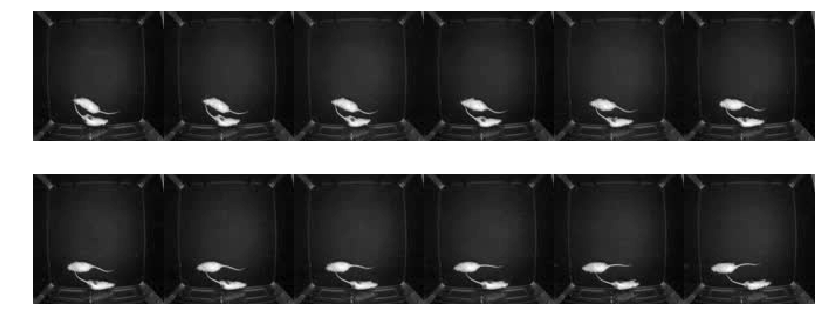

In [35]:
fig, axs = plt.subplots(2, segment_length/2, figsize=(14,6))
for i in range(axs.size):
    axs.flat[i].imshow(input_data[0, 0, i, :]+40);
    axs.flat[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
# copy the image data into the memory allocated for the net
net.blobs[input_name].data[...] = input_data

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax(), labels[output_prob.argmax()]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'top 5 probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

---

### Exploring layers

In [9]:
# for each layer, show the output shape
print 'Layer output shapes:'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    
print
print 'Layer parameter shapes:'
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

Layer output shapes:
data	(1, 3, 12, 112, 112)
conv1a	(1, 64, 12, 112, 112)
pool1	(1, 64, 12, 56, 56)
conv2a	(1, 128, 12, 56, 56)
pool2	(1, 128, 6, 28, 28)
conv3a	(1, 256, 6, 28, 28)
pool3	(1, 256, 3, 14, 14)
conv4a	(1, 256, 3, 14, 14)
pool4	(1, 256, 3, 13, 13)
conv5a	(1, 256, 1, 13, 13)
pool5	(1, 256, 1, 7, 7)
fc6	(1, 2048)
fc7	(1, 2048)
fc8	(1, 6)
prob	(1, 6)

Layer parameter shapes:
conv1a	(64, 3, 3, 3, 3) (64,)
conv2a	(128, 64, 3, 3, 3) (128,)
conv3a_ratsi	(256, 128, 3, 3, 3) (256,)
conv4a_ratsi	(256, 256, 3, 3, 3) (256,)
conv5a_ratsi	(256, 256, 3, 3, 3) (256,)
fc6_ratsi	(2048, 12544) (2048,)
fc7_ratsi	(2048, 2048) (2048,)
fc8_ratsi	(6, 2048) (6,)


In [10]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data.squeeze()); plt.axis('off')

In [12]:
filters.shape

(64, 3, 3, 3, 3)

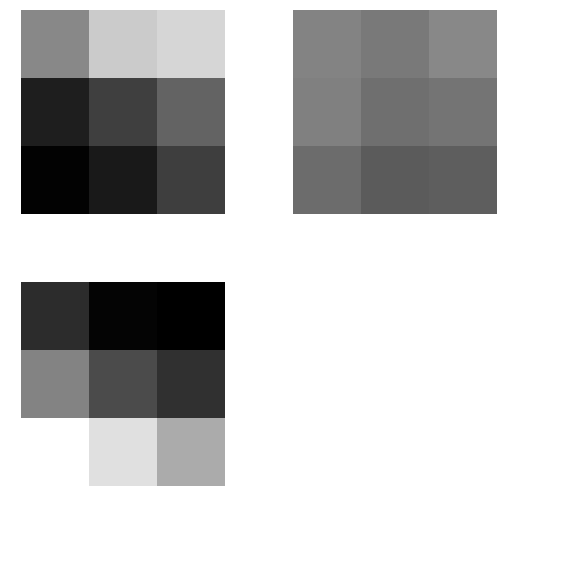

In [37]:
filters = net.params['conv1a'][0].data
vis_square(filters[0, :, 0, :])

/home/malte/anaconda2/envs/rbr_cnn/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


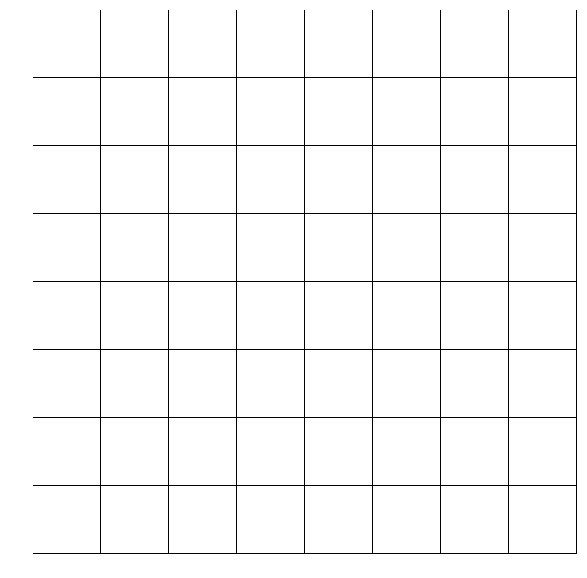

In [41]:
feat = net.blobs['conv1a'].data[0, :]
vis_square(feat)

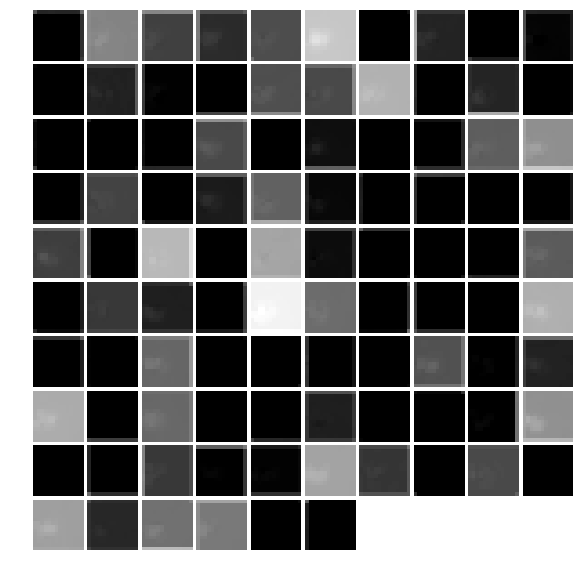

In [39]:
feat = net.blobs['pool2_f'].data[0]
vis_square(feat)

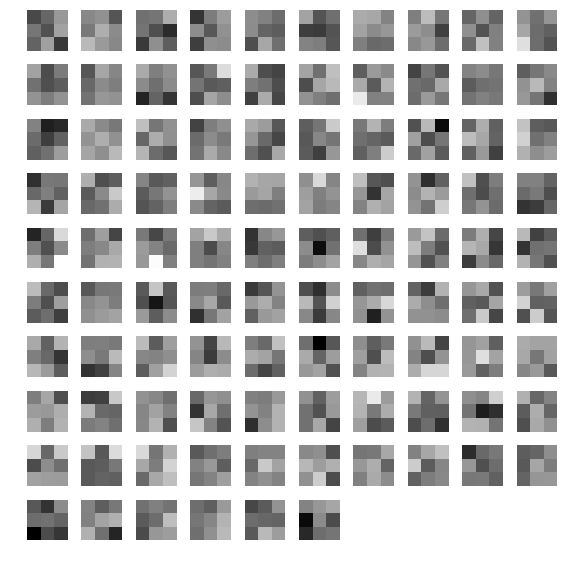

In [41]:
filters = net.params['conv3_f'][0].data
vis_square(filters.transpose(0, 2, 3, 1)[:,:,:,1])